In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('code_mixed.csv')

In [3]:
data.head()

,Mixed_Code
0,Ye song nahi hi Ye MODI Ji ka mehnat ka rang h...
1,Love u sir love u soo much urs I'ts beautyful ...
2,Arae sur jee pahelae hamare bharat ke bachho k...
3,Wah! Jitni sundar geet ke bhao hain utnihi sun...
4,Sundar ekdam sahi Gaya Hua gana.chhotisi gudiy...


In [4]:
data.tail()

,Mixed_Code
3874,Cool movie bajarangi bhaijan osm ??
3875,Salman sahab aap to meri aawaj sunenge nahi.Ph...
3876,sir aap dil jeet liya kya movie ti
3877,Salman sir bahot acchi movie hai super hit blo...
3878,awssmmm movie salman sirrrr super salman sirrrr


In [5]:
data.describe()

,Mixed_Code
count,3879
unique,3879
top,Salman bhai kaha hai
freq,1


In [6]:
data.shape

(3879, 1)

In [7]:
data.info

<bound method DataFrame.info of                                              Mixed_Code
0     Ye song nahi hi Ye MODI Ji ka mehnat ka rang h...
1     Love u sir love u soo much urs I'ts beautyful ...
2     Arae sur jee pahelae hamare bharat ke bachho k...
3     Wah! Jitni sundar geet ke bhao hain utnihi sun...
4     Sundar ekdam sahi Gaya Hua gana.chhotisi gudiy...
...                                                 ...
3874                Cool movie bajarangi bhaijan osm ??
3875  Salman sahab aap to meri aawaj sunenge nahi.Ph...
3876                 sir aap dil jeet liya kya movie ti
3877  Salman sir bahot acchi movie hai super hit blo...
3878    awssmmm movie salman sirrrr super salman sirrrr

[3879 rows x 1 columns]>

In [10]:
data = data.drop(['Mixed_Code'], axis=1)

In [11]:
def tokenize(word, alphabet=set('qwertyuiopasdfghjklzxcvbnm'), preprocess=True):
    if preprocess:
        word = word.strip().lower() 
    return ''.join([c if c in alphabet else ' ' + c + ' ' for c in word]).strip().split()

class DeepTranslit():
    params = None
    model = None
    cache = {}

    def _init_(self, lang_code):
        """
        Initialize deeptranslit
        Parameters:
        lang_code (str): Name or code of the language. (Currently supported: hindi/hi)
        """

        if lang_code in lang_code_mapping:
            lang_code = lang_code_mapping[lang_code]
        
        if lang_code not in model_links:
            print("DeepTranslit doesn't support '" + lang_code + "' yet.")
            print("Please raise a issue at https://github.com/bedapudi6788/deeptranslit to add this language into future checklist.")
            return None
        
        # loading the model
        home = os.path.expanduser("~")
        lang_path = os.path.join(home, '.DeepTranslit_' + lang_code)
        checkpoint_path = os.path.join(lang_path, 'checkpoint')
        params_path = os.path.join(lang_path, 'params')
        
        if not os.path.exists(lang_path):
            os.mkdir(lang_path)

        if not os.path.exists(checkpoint_path):
            print('Downloading checkpoint', model_links[lang_code]['checkpoint'], 'to', checkpoint_path)
            pydload.dload(url=model_links[lang_code]['checkpoint'], save_to_path=checkpoint_path, max_time=None)

        if not os.path.exists(params_path):
            print('Downloading model params', model_links[lang_code]['params'], 'to', params_path)
            pydload.dload(url=model_links[lang_code]['params'], save_to_path=params_path, max_time=None)
        
        self.model, self.params = build_model(params_path=params_path, enc_lstm_units=64, use_gru=True, display_summary=False)
        self.model.load_weights(checkpoint_path)


    def transliterate_words(self, in_words, top_n=1):
        """
        Transliterate an input word while preserving unknown tokens.
        Parameters:
        sent (str): word(s) to be transliterated.
        top (int): top-n results to be returned. | also the beam size
        Returns:
        list: returns list of dicts eg: [{'pred': string, 'prob': float}, {'pred': string, 'prob': float}, ..] per each input.
        """
        return_single = False
        if not isinstance(in_words, list):
            return_single = True
            in_words = [in_words]

        orig_to_tokenized_map = {}
        for in_word in in_words:
            orig_to_tokenized_map[in_word] = tokenize(in_word, alphabet=self.params['input_encoding'], preprocess=True)
        
        unique_tokens = set()
        for in_word, tokens in orig_to_tokenized_map.items():
            for token in tokens:
                if [c for c in token if c not in self.params['input_encoding']] or token in self.cache:
                    continue

                unique_tokens.add(token)
        
        unique_tokens = list(unique_tokens)

        if unique_tokens:
            unique_token_preds = infer(unique_tokens, self.model, self.params, max_beams=top_n, cut_off_ratio=2)
            self.cache.update({token: token_pred for token, token_pred in zip(unique_tokens, unique_token_preds)})

        all_preds = []

        for in_word in in_words:
            if in_word not in orig_to_tokenized_map:
                all_preds.append([{'pred': in_word, 'prob': 1}])
            else:
                preds = itertools.product(*[self.cache.get(token, [{'sequence': token, 'prob': 1}]) for token in orig_to_tokenized_map[in_word]])
                preds = [{'pred': ''.join([p['sequence'] for p in pred]), 'prob': numpy.prod([p['prob'] for p in pred])} for pred in preds]
                preds = sorted(preds, key=lambda x: x['prob'], reverse=True)[:top_n]
                all_preds.append(preds)
        
        if return_single:
            all_preds = all_preds[0]

        return all_preds
                    

    def transliterate(self, sents, top_n=1):
        """
        Transliterate an input sentence while preserving unknown tokens.
        Parameters:
        sent (str): Sentence(s) to be transliterated.
        top (int): top-n results to be returned. | also the beam size
        Returns:
        list: returns list of dicts eg: [{'pred': string, 'prob': float}, {'pred': string, 'prob': float}, ..] per each input.
        """
        return_single = False
        if not isinstance(sents, list):
            return_single = True
            sents = [sents]

        sents = [' '.join(sent.strip().split()) for sent in sents]

        all_unique_words = list(set(' '.join(sents).split()))
        word_preds = self.transliterate_words(all_unique_words, top_n=top_n)
        word_preds = {w: p for w, p in zip(all_unique_words, word_preds)}

        sent_preds = []

        for sent in sents:
            preds = itertools.product(*[word_preds.get(w, [{'pred': w, 'prob': 1}]) for w in sent.split()])
            preds = [{'pred': ' '.join([p['pred'] for p in pred]), 'prob': numpy.prod([p['prob'] for p in pred])} for pred in preds]
            preds = sorted(preds, key=lambda x: x['prob'], reverse=True)[:top_n]
            sent_preds.append(preds)

        if return_single:
            sent_preds = sent_preds[0]

        return sent_preds

In [14]:
data.head()

""
0
1
2
3
4


In [12]:
!pip install googletrans
!pip install vadersentiment

{'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'compound': 0.8519}
{'neg': 0.0, 'neu': 0.543, 'pos': 0.457, 'compound': 0.8555}
{'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compound': -0.4588}
{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.636}
{'neg': 0.0, 'neu': 0.427, 'pos': 0.573, 'compound': 0.7717}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'compound': 0.5719}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.4767}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'compound': 0.9246}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'compound': 0.2263}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.048, 'neu': 0.623, 'pos': 0.329, 'compound': 0.8442}
{'neg': 0.0,

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.4404}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.2732}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.085, 'neu': 0.915, 'pos': 0.0, 'compound': -0.5574}
{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'compound': 0.6697}
{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'compound': 0.1531}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.149, 'neu': 0.851, 'pos': 0.0, 'compound': -0.1027}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0,

{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.4588}
{'neg': 0.0, 'neu': 0.579, 'pos': 0.421, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'compound': 0.3182}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.128, 'neu': 0.817, 'pos': 0.055, 'compound': -0.3637}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'compound': 0.34}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.9, 'pos': 0.1, 'compound': 0.6249}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.132, 'neu': 0.542, 'pos': 0.325, 'compound': 0.4946}
{'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'compound': 0.8834}
{'neg': 0.0, 'neu': 0.76

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.181, 'neu': 0.702, 'pos': 0.117, 'compound': -0.2732}
{'neg': 0.351, 'neu': 0.649, 'pos': 0.0, 'compound': -0.4019}
{'neg': 0.0, 'neu': 0.642, 'pos': 0.358, 'compound': 0.7717}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.172, 'neu': 0.828, 'pos': 0.0, 'compound': -0.4019}
{'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'compound': 0.4215}
{'neg': 0.0, 'neu': 0.722, 'pos': 0.278, 'compound': 0.4019}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'compound': 0.3182}
{'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'compound': 0.3182}
{'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'compound': 0.8555}
{'neg': 0.0, 'neu': 0.792, 'pos': 0.208, 'compound': 0.3875}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg':

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.898, 'pos': 0.102, 'compound': 0.1531}
{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4939}
{'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'compound': 0.3612}
{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'compound': 0.7579}
{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4215}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'compound': 0.2716}
{'neg': 0.0, 'neu': 0.566, 'pos': 0.434, 'compound': 0.3182}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.536, 'pos': 0.464, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'compound': 0.5267}
{'neg': 0.211, 'neu': 0.789, 'pos': 0.0, 'compound': -0.34}
{'neg': 0.0, 

{'neg': 0.0, 'neu': 0.92, 'pos': 0.08, 'compound': 0.0772}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.267, 'pos': 0.733, 'compound': 0.6705}
{'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'compound': 0.25}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.3182}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.413, 'pos': 0.587, 'compound': 0.8957}
{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.5574}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compou

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.211, 'neu': 0.789, 'pos': 0.0, 'compound': -0.34}
{'neg': 0.155, 'neu': 0.845, 'pos': 0.0, 'compound': -0.296}
{'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'compound': 0.6369}
{'neg': 0.095, 'neu': 0.905, 'pos': 0.0, 'compound': -0.296}
{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'compound': 0.6369}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'compound': 0.6597}
{'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'compound': 0.6908}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.894, 'pos': 0.106, 'compound': 0.3612}
{'neg': 0.0, 'neu': 0.441, 'pos': 0.559, 'compound': 0.5859}
{'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'compound': -0.4767}
{'neg': 0.0, 'neu': 0.412, 'pos': 0.588, 'compound': 0.875}
{'neg': 0.119, 'neu': 0.881, 'pos': 0.0, 'compound': -0.4019

{'neg': 0.116, 'neu': 0.884, 'pos': 0.0, 'compound': -0.2411}
{'neg': 0.0, 'neu': 0.27, 'pos': 0.73, 'compound': 0.4019}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'compound': 0.4019}
{'neg': 0.163, 'neu': 0.667, 'pos': 0.17, 'compound': 0.0258}
{'neg': 0.179, 'neu': 0.821, 'pos': 0.0, 'compound': -0.34}
{'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'compound': 0.5719}
{'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'compound': 0.4404}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.49, 'pos': 0.51, 'compound': 0.9393}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.123, 'neu': 0.584, 'pos': 0.292, 'compound': 0.3818}
{'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'compound': 0.4019}
{'neg'

{'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'compound': 0.5719}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.494, 'pos': 0.506, 'compound': 0.6249}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'compound': 0.0258}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.16, 'neu': 0.738, 'pos': 0.102, 'compound': -0.34}
{'neg': 0.0, 'neu': 0.722, 'pos': 0.278, 'compound': 0.4019}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compound': 0.4588}
{'neg': 0.0, 'neu': 0.105, 'pos': 0.895, 'compound': 0.8176}
{'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'compound': 0.5994}
{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.2732}
{'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'compound': 0.5994}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg':

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4939}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.211, 'neu': 0.789, 'pos': 0.0, 'compound': -0.34}
{'neg': 0.307, 'neu': 0.693, 'pos': 0.0, 'compound': -0.4767}
{'neg': 0.217, 'neu': 0.472, 'pos': 0.311, 'compound': 0.25}
{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'compound': 0.5719}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.197, 'pos': 0.803, 'compound': 0.8466}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.244, 'neu': 0.756, 'pos': 0.0, 'compound': -0.6705}
{'neg': 0.0, 'neu': 0.955, 'pos'

{'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'compound': 0.0382}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.126, 'pos': 0.874, 'compound': 0.9933}
{'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compound': 0.3252}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.235, 'pos': 0.765, 'compound': 0.7579}
{'neg': 0.0, 'neu': 0.357, 'pos': 0.643, 'compound': 0.8957}
{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.2732}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.5994}
{'neg': 0.0, 'neu': 0.719, 'pos': 0.281, 'compound': 0.5994}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'compound': -0.4767}
{'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'compound': 0.4754}
{'neg': 0.0, 'neu': 0.365, 'pos': 0.635, 'compound': 0.9041}
{'neg'

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'compound': 0.6705}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'compound': 0.765}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.673, 'pos': 0.327, 'compound': 0.5984}
{'neg': 0.171, 'neu': 0.778, 'pos': 0.051, 'compound': -0.6249}
{'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'compound': -0.4939}
{'neg': 0.0, 'neu': 0.907, 'pos': 0.093, 'compound': 0.3094}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.037, 'neu': 0.797, 'pos': 0.166, 'compound': 0.7785}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'compound': 0.0772}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.86, 'pos': 0.14, 'compound': 0.0772}
{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.42, 'neu': 0.58, 'pos': 0.0, 'compound': -0.4404}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.054, 'neu': 0.8, 'pos': 0.146, 'compound': 0.4714}
{'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'compound': 0.3612}
{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.3182}
{'neg': 0.126, 'neu': 0.874, 'pos': 0.0, 'compound': -0.1139}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.667, 'pos': 0

{'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'compound': 0.4215}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.187, 'neu': 0.557, 'pos': 0.255, 'compound': 0.0864}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'compound': 0.5859}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.483, 'pos': 0.517, 'compound': 0.9657}
{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'compound': 0.3182}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'compound': 0.34}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'co

{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'compound': 0.0772}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'compound': 0.7387}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4939}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.79, 'pos': 0.21, 'compound': 0.5362}
{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'compound': 0.3182}
{'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'compound': 0.5574}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.619, 'pos': 0.381, 'compound': 0.5106}
{'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'compound': 0.5719}
{'neg': 0.0, 'neu': 0.856, 'pos': 0.144, 'compound': 0.6369}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'compound': 0.5423}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, '

{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.3818}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'compound': 0.5574}
{'neg': 0.145, 'neu': 0.855, 'pos': 0.0, 'compound': -0.2584}
{'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'compound': 0.4019}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.417, 'neu': 0.583, 'pos': 0.0, 'compound': -0.4329}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'compound': 0.3182}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.34}
{'neg': 0.0, 'neu': 0.742, 'pos': 0.258, 'compound': 0.4168}
{'neg': 0.26, 'neu': 0.74, 'pos': 0.0, 'compound': -0.2755}
{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'compound': 0.3412}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.5574}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.6369}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'compound': 0.5965}
{'neg': 0.276, 'neu': 0.724, 'pos': 0.0, 'compound': -0.6369}
{'neg': 0.0, 'neu': 0.676, 'pos': 0.324, 'compound': 0.802}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'compound': 0.4019}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.827, 'pos': 0.173, 'compound': 0.3182}
{'neg': 0.0, 'neu': 0.741, 'pos':

{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'compound': 0.4019}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.376, 'pos': 0.624, 'compound': 0.8519}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.173, 'neu': 0.827, 'pos': 0.0, 'compound': -0.3182}
{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.4939}
{'neg': 0.176, 'neu': 0.431, 'pos': 0.392, 'compound': 0.6705}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'compound': 0.4588}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.568, 'pos': 0.432, 'compound': 0.5859}
{'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'compound': 0.5719}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0

{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'compound': -0.3412}
{'neg': 0.109, 'neu': 0.789, 'pos': 0.102, 'compound': -0.0516}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.474, 'pos': 0.526, 'compound': 0.7906}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'compound': 0.0772}
{'neg': 0.166, 'neu': 0.696, 'pos': 0.138, 'compound': -0.1335}
{'neg': 0.0, 'neu': 0.96, 'pos': 0.04, 'compound': 0.0772}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.236, 'neu': 0.428, 'pos': 0.336, 'compound': 0.2359}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'compound': 0.3182}
{'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'compound': 0.5719}
{'neg': 0.0,

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.172, 'neu': 0.538, 'pos': 0.29, 'compound': 0.2732}
{'neg': 0.0, 'neu': 0.86, 'pos': 0.14, 'compound': 0.0772}
{'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'compound': -0.4717}
{'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'compound': 0.0772}
{'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.7003}
{'neg': 0.0, 'neu': 0.97, 'pos': 0.03, 'compound': 0.0772}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'compound': 0.3612}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.6369}
{'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'compound': -0.2732}
{'neg': 0.0, 'neu': 

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.101, 'neu': 0.899, 'pos': 0.0, 'compound': -0.4215}
{'neg': 0.266, 'neu': 0.734, 'pos': 0.0, 'compound': -0.4404}
{'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'compound': -0.1531}
{'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'compound': 0.6486}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.211, 'neu': 0.789, 'pos': 0.0, 'compound': -0.4939}
{'neg': 0.268, 'neu': 0.282, 'pos': 0.451, 'compound': 0.3182}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.45, 'pos': 0.55, 'compound': 0.7269}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.209, 'neu': 0.791, 'pos': 0.0, 'compound': -0.2755}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.6369}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.776, 'pos': 0.224, 'compound': 0.3818}
{'neg':

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.619, 'pos': 0.381, 'compound': 0.5106}
{'neg': 0.137, 'neu': 0.705, 'pos': 0.159, 'compound': 0.128}
{'neg': 0.0, 'neu': 0.712, 'pos': 0.288, 'compound': 0.5632}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'compound': -0.6369}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'compound': 0.4588}
{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'compound': -0.357}
{'neg': 0.341, 'neu': 0.659, 'pos': 0.0, 'compound': -0.4767}
{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.3182}
{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.4019}
{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.3182}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'compound': 0.34}
{'ne

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.159, 'pos': 0.841, 'compound': 0.6486}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.884, 'pos': 0.116, 'compound': 0.2732}
{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compound': 0.4019}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.381, 'neu': 0.619, 'pos': 0.0, 'compound': -0.6486}
{'neg': 0.09, 'neu': 0.657, 'pos': 0.253, 'compound': 0.607}
{'neg': 0.241, 'neu': 0.613, 'pos': 0.146, 'compound': -0.2197}
{'neg': 0.744, 'neu': 0.256, 'pos': 0.0, 'compound': -0.4404}
{'neg': 0.0, 'neu': 0.137, 'pos': 0.863, 'compound': 0.9274}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.4939}
{'neg': 0.0, 'neu': 0.692, 'pos': 0.308, 'compound': 0.9565}
{'neg': 0.109, 'neu': 0.842, 'pos': 0.049, 'compound': -0.4019}
{'neg': 0.117, 'neu': 0.384, 'pos': 0.499, 'compound'

{'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compound': -0.4939}
{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.7579}
{'neg': 0.0, 'neu': 0.471, 'pos': 0.529, 'compound': 0.5423}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.649, 'pos': 0.351, 'compound': 0.4019}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'compound': 0.5859}
{'neg': 0.07, 'neu': 0.88, 'pos': 0.05, 'compound': -0.2263}
{'neg': 0.327, 'neu': 0.673, 'pos': 0.0, 'compound': -0.5267}
{'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'compound': 0.0772}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'compound': 0.6486}
{'neg': 0.25

{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'compound': 0.3182}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.773, 'neu': 0.227, 'pos': 0.0, 'compound': -0.5267}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.292, 'neu': 0.708, 'pos': 0.0, 'compound': -0.5106}
{'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'compound': 0.8225}
{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'compound': -0.5267}
{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.5994}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.076, 'neu': 0.924, 'pos': 0.0, 'compound': -0.2411}
{'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.743}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.232, 'neu': 0.634, 'pos': 0.134, 'compound': -0.34}
{'neg': 0.0, 'neu': 0.146, 'pos': 0.854, 'compound': 0.9136}
{'neg': 

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.599, 'pos': 0.401, 'compound': 0.7713}
{'neg': 0.324, 'neu': 0.676, 'pos': 0.0, 'compound': -0.34}
{'neg': 0.0, 'neu': 0.355, 'pos': 0.645, 'compound': 0.8979}
{'neg': 0.0, 'neu': 0.125, 'pos': 0.875, 'compound': 0.7906}
{'neg': 0.147, 'neu': 0.63, 'pos': 0.223, 'compound': 0.3506}
{'neg': 0.0, 'neu': 0.738, 'pos': 0.262, 'compound': 0.4939}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6222}
{'neg': 0.0, 'neu': 0.339, 'pos': 0.661, 'compound': 0.5994}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4215}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'compound': 0.5574}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0,

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.405, 'pos': 0.595, 'compound': 0.8316}
{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'compound': 0.4019}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.179, 'neu': 0.597, 'pos': 0.224, 'compound': 0.1531}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'compound': -0.34}
{'neg': 0.0, 'neu': 0.607, 'pos': 0.393, 'compound': 0.8555}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.636, 'pos': 0.364, 'compound': 0.4588}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.721, 'pos': 0.279, 'compound': 0.4767}
{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.9118}
{'neg': 0.0, 'neu': 0.664, 'pos': 0.336, 'compound': 0.8442}
{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.774, 'pos': 0.226, 'compound': 0.5859}
{'ne

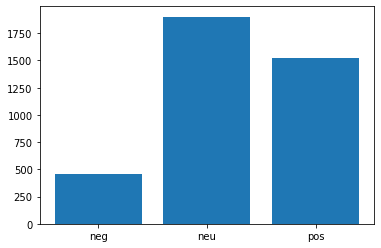

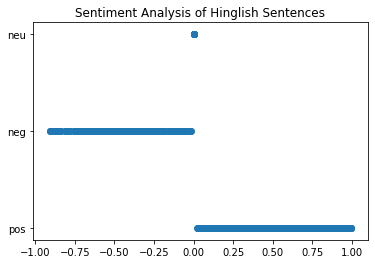

In [15]:
from googletrans import Translator
import xlrd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

translator = Translator()

wb = xlrd.open_workbook("codemix.xlsx")
sheet = wb.sheet_by_index(0) 
num_rows = sheet.nrows

x_axis = ["neg", "neu", "pos"]
y_axis = [0, 0, 0]

scatter_x = []
scatter_y = []

for i in range(1, num_rows):
    sentence = sheet.cell_value(i,0)
    translations = translator.translate(sentence.encode('unicode-escape').decode('ASCII'), dest='en')
    trans_text = translations.text
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(trans_text)
    
    print(result)

    if(result["compound"] < 0):
        y_axis[0] += 1
        scatter_x.append(result["compound"])
        scatter_y.append("neg")

    if(result["compound"] == 0):
        y_axis[1] += 1
        scatter_x.append(result["compound"])
        scatter_y.append("neu")
    
    if(result["compound"] > 0):
        y_axis[2] += 1
        scatter_x.append(result["compound"])
        scatter_y.append("pos")

bar_graph = plt.figure(1)
plt.bar(x_axis, y_axis)

scatter_plot = plt.figure(2)
plt.scatter(scatter_x, scatter_y)

plt.title("Sentiment Analysis of Hinglish Sentences")

plt.show()